# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Read The Data
First, we need to take a look at the data structure and attributes.
We want to find correlations that can predict useful information. 

In [90]:
import pandas as pd

CSV_FILENAME = "steel_plate.csv" 
CSV_FOLDER_NAME = "Datasets"
CSV_FILEPATH = os.path.join(CSV_FOLDER_NAME, CSV_FILENAME)

try:
    raw_data = pd.read_csv(CSV_FILEPATH)
except Exception as e:
    print(e)

raw_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


# Forklaring av attributter i datasettet

## Geometriske attributter (X/Y-koordinater og områder)
- **X_Minimum**: Venstre kant av feilen i bildet  
- **X_Maximum**: Høyre kant av feilen i bildet  
- **Y_Minimum**: Øvre kant av feilen i bildet  
- **Y_Maximum**: Nedre kant av feilen i bildet  
- **Pixels_Areas**: Antall piksler som utgjør feilen (størrelsen på feilen)  
- **X_Perimeter**: Lengden av feilen i X-retning  
- **Y_Perimeter**: Lengden av feilen i Y-retning  

## Lysstyrke-attributter (Luminosity)
- **Sum_of_Luminosity**: Summen av lysstyrkeverdier i feilen  
- **Minimum_of_Luminosity**: Laveste lysstyrkeverdi i feilen  
- **Maximum_of_Luminosity**: Høyeste lysstyrkeverdi i feilen  
- **Luminosity_Index**: Indeks som oppsummerer lysstyrkeegenskaper  

## Materialegenskaper
- **Length_of_Conveyer**: Hvor langt stålplaten har beveget seg i produksjonslinjen  
- **TypeOfSteel_A300**: Indikerer om stålplaten er av type A300 (1 = Ja, 0 = Nei)  
- **TypeOfSteel_A400**: Indikerer om stålplaten er av type A400 (1 = Ja, 0 = Nei)  
- **Steel_Plate_Thickness**: Tykkelsen på stålplaten  

## Kant- og formrelaterte attributter
- **Edges_Index**: Hvor mye av feilen som ligger nær kanten  
- **Empty_Index**: Hvorvidt det er et tomt område rundt feilen  
- **Square_Index**: Om feilen har en firkantet form  
- **Outside_X_Index**: Om feilen er utenfor hovedområdet i X-retning  
- **Edges_X_Index**: Hvordan feilen fordeler seg i X-retning  
- **Edges_Y_Index**: Hvordan feilen fordeler seg i Y-retning  
- **Outside_Global_Index**: Om feilen er utenfor hovedområdet globalt  
- **Orientation_Index**: Om feilen er mer horisontal eller vertikal  

## Log-transformerte og skalerte verdier
- **LogOfAreas**: Logaritmisk transformert versjon av Pixels_Areas  
- **Log_X_Index**: Logaritmisk transformert X-posisjon  
- **Log_Y_Index**: Logaritmisk transformert Y-posisjon  
- **SigmoidOfAreas**: Sigmoid-transformert versjon av Pixels_Areas  

## Feiltyper (målvariabler, en av disse er 1, resten 0)
- **Pastry**: Feilklassifisering: Pastry  
- **Z_Scratch**: Feilklassifisering: Z-formet ripe  
- **K_Scatch**: Feilklassifisering: K-formet ripe  
- **Stains**: Feilklassifisering: Flekker  
- **Dirtiness**: Feilklassifisering: Skitt/smuss  
- **Bumps**: Feilklassifisering: Bulker  
- **Other_Faults**: Feilklassifisering: Andre feil  

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [6]:
raw_data.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


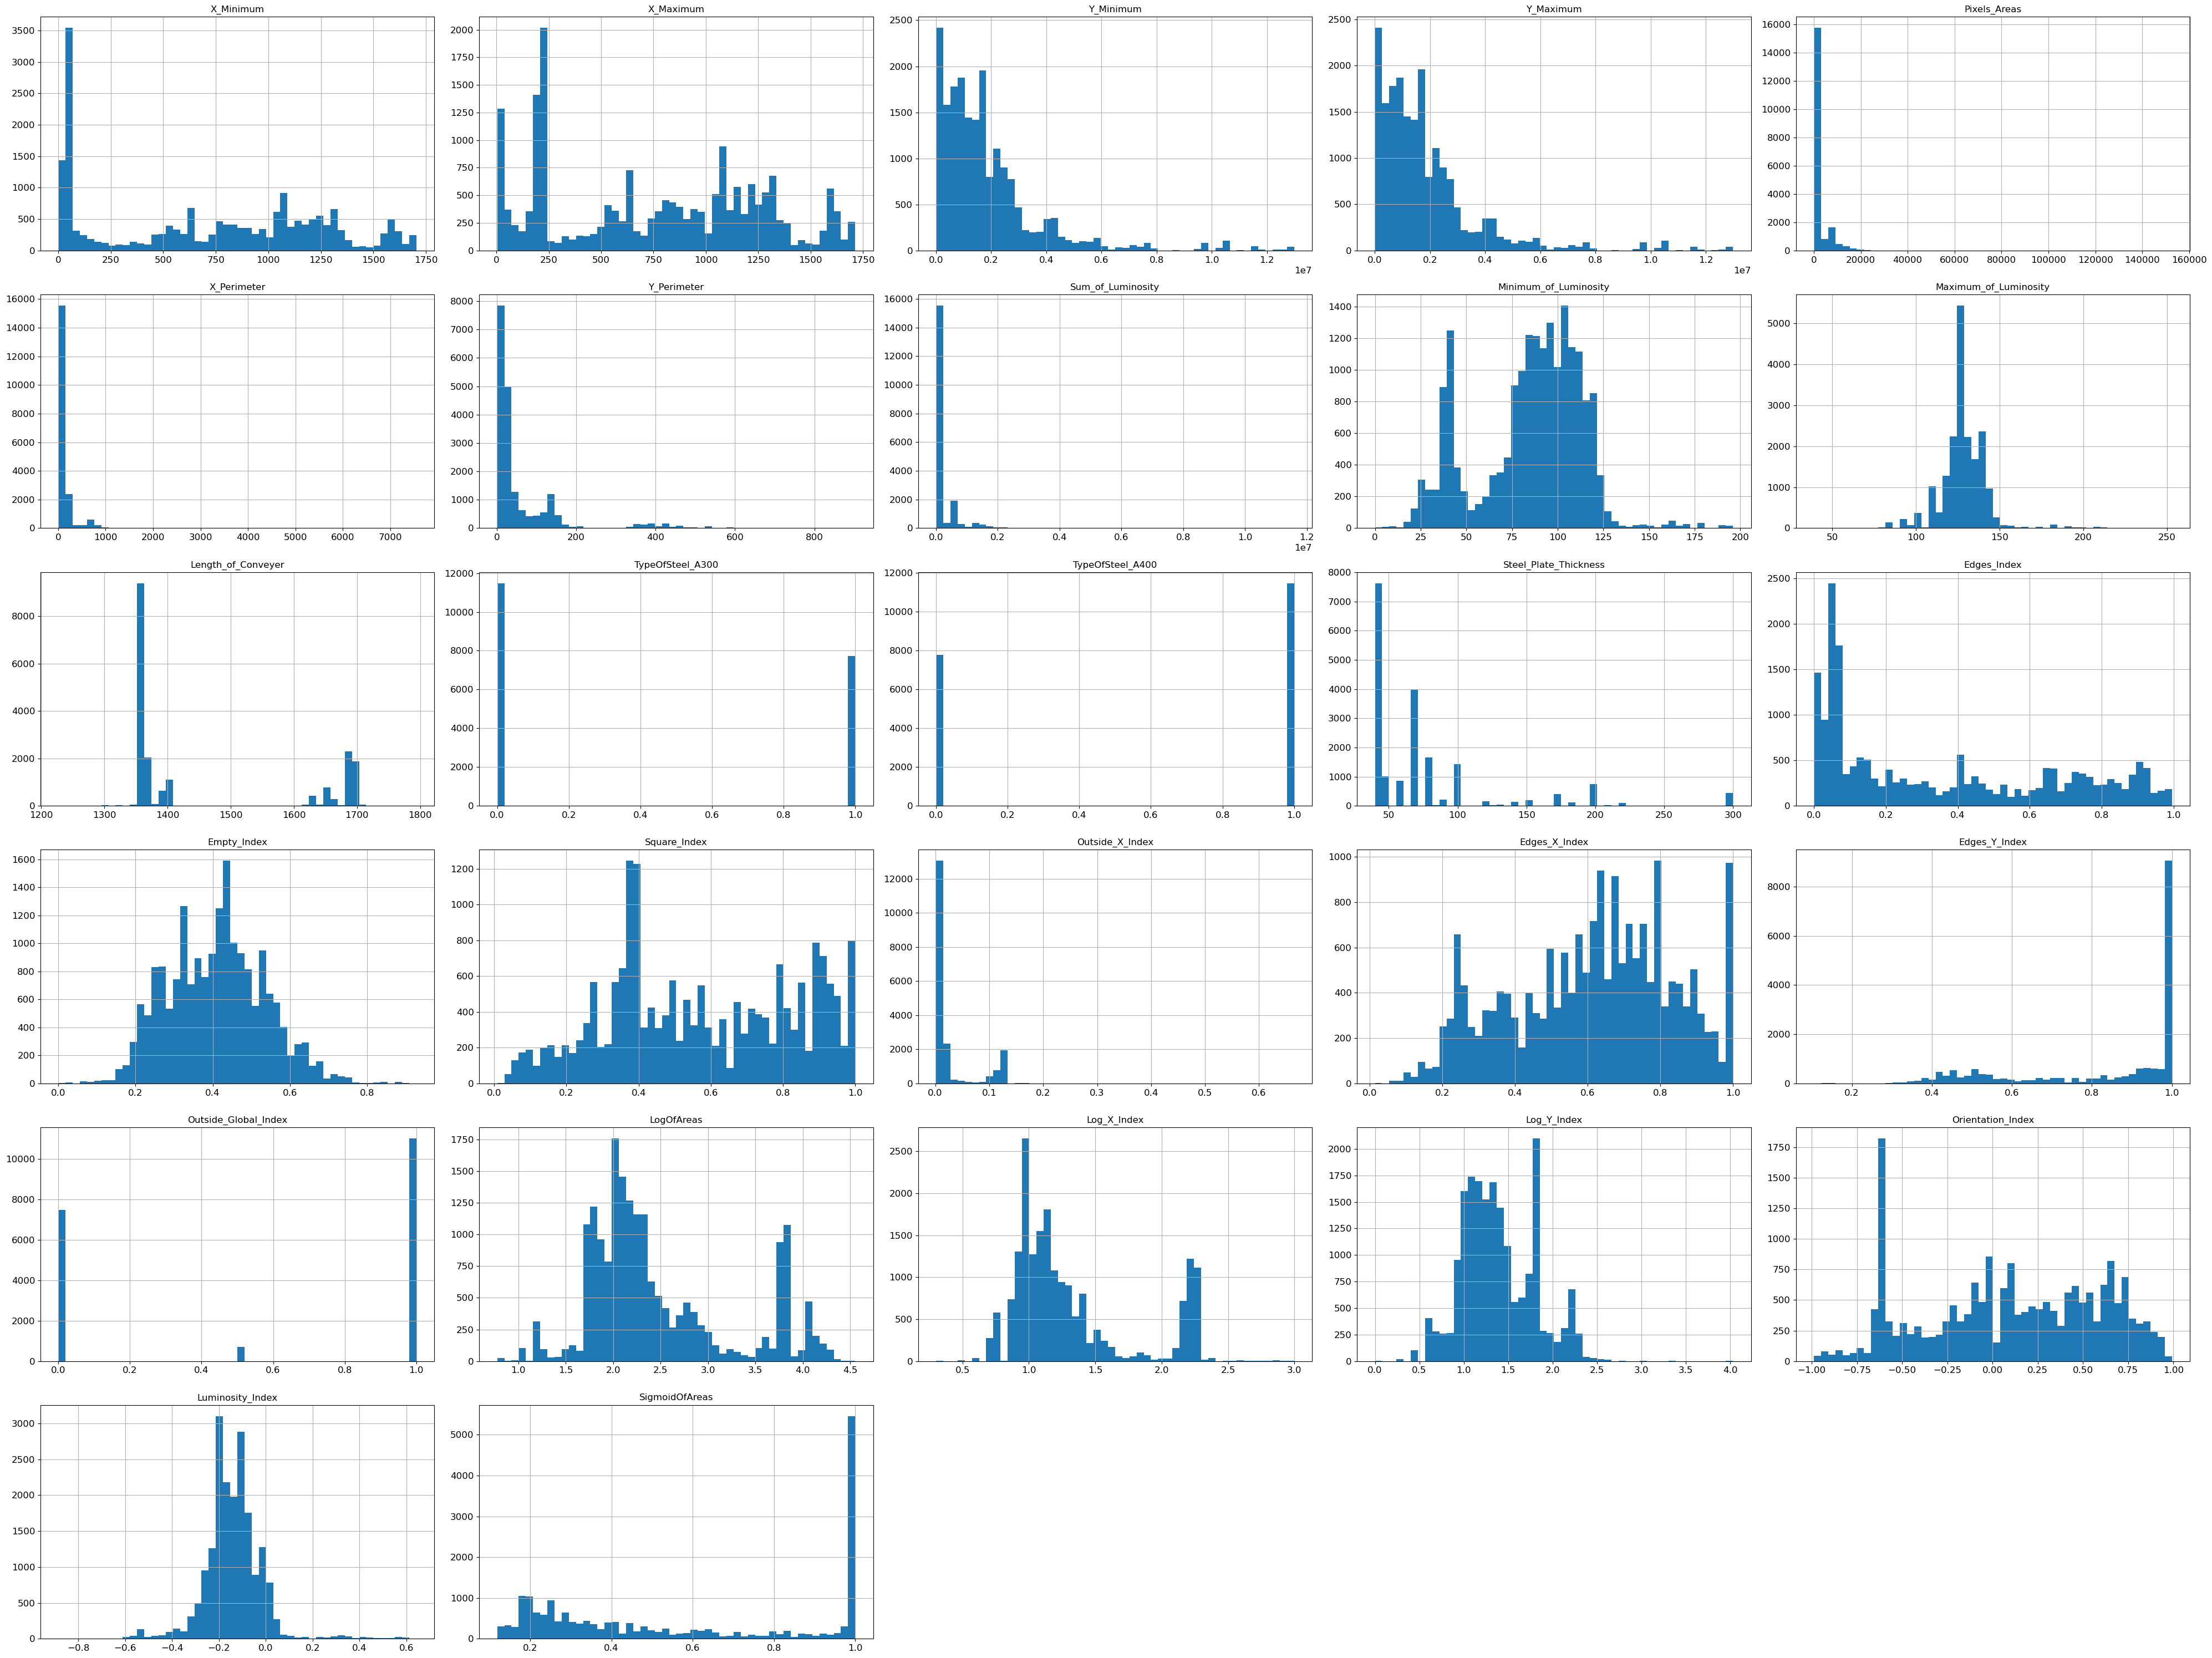

In [ ]:
import matplotlib.pyplot as plt

#TODO: Lag et penere plot

selected_atributes = raw_data[["X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas","X_Perimeter","Y_Perimeter","Sum_of_Luminosity","Minimum_of_Luminosity","Maximum_of_Luminosity","Length_of_Conveyer","TypeOfSteel_A300","TypeOfSteel_A400","Steel_Plate_Thickness","Edges_Index","Empty_Index","Square_Index","Outside_X_Index","Edges_X_Index","Edges_Y_Index","Outside_Global_Index","LogOfAreas","Log_X_Index","Log_Y_Index","Orientation_Index","Luminosity_Index","SigmoidOfAreas"]]
selected_atributes.hist(bins=50, figsize=(40,30))
plt.show()

In [8]:
# Look for NaN values
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


In [9]:
# Drop ID collum
raw_data_drop_id = raw_data.drop(columns=["id"])
raw_data_drop_id

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,749,757,143210,143219,17,4,4,2193,122,140,...,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,723,735,2488529,2488541,231,17,26,27135,104,133,...,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,6,31,1578055,1578129,780,114,98,71112,41,94,...,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0
19217,9,18,1713172,1713184,126,13,26,14808,88,132,...,0.9610,-0.1162,0.3509,0,0,0,0,0,0,1


In [40]:
# Split into features and target
targets = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
features = [col for col in raw_data_drop_id.columns if col not in targets]

## Look for corelations

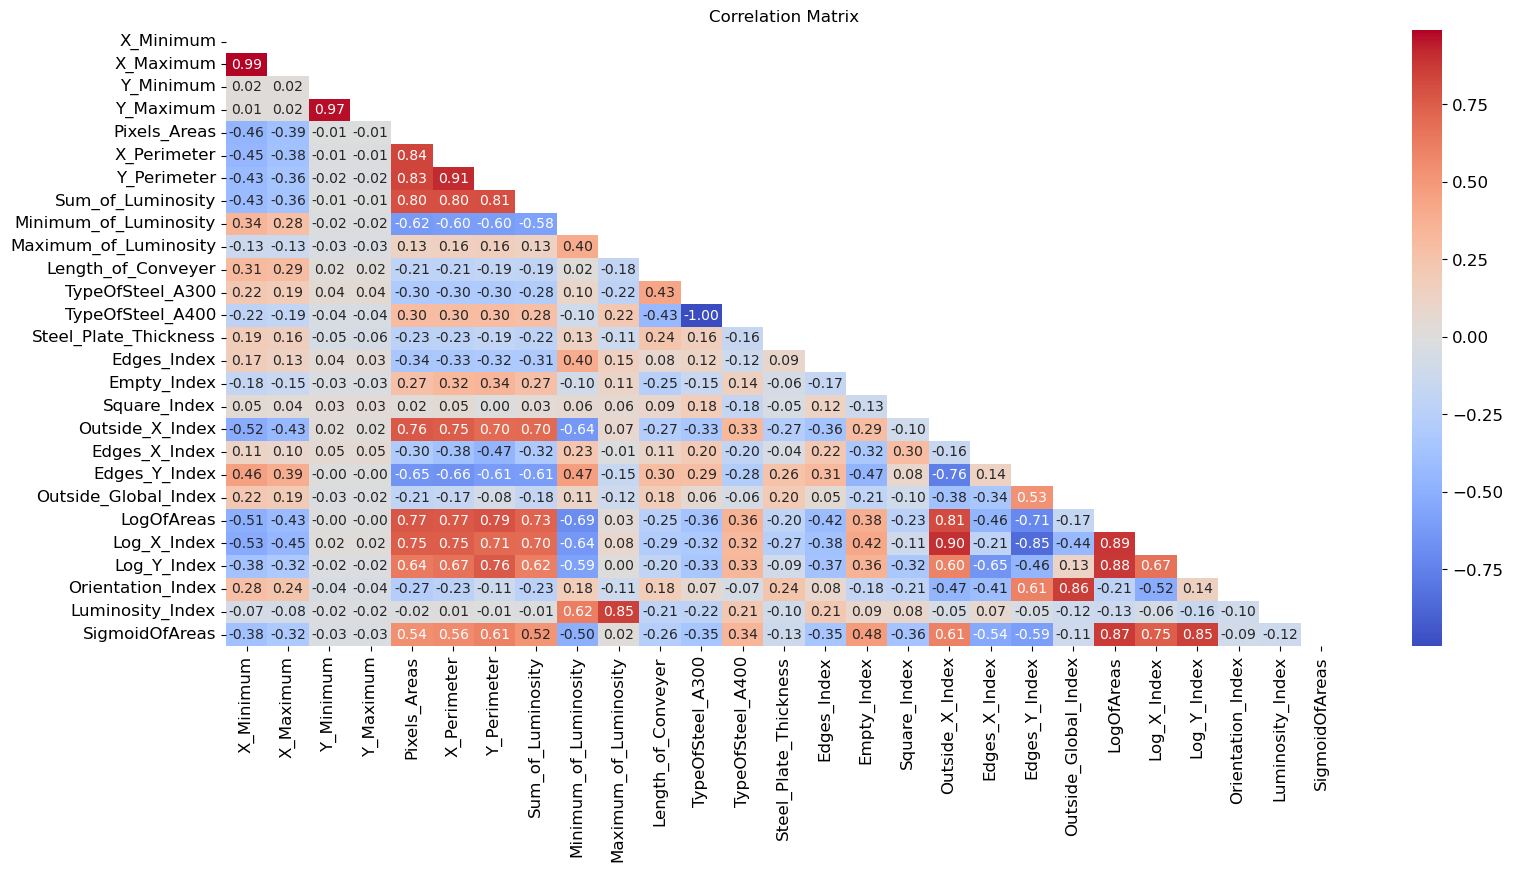

In [62]:
import seaborn as sns

corr = raw_data_drop_id[features].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show() 

# **Preparing The Data For Training**

In [12]:
exclude_scaling = ["TypeOfSteel_A300","TypeOfSteel_A400"] # TODO: finn ut hvilke som ikke skal skaleres
exclude_scaling = []
columns_to_scale = [col for col in features if col not in exclude_scaling]

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
# Prepare the train data
scaled_data = raw_data_drop_id.copy()
scaled_data[columns_to_scale] = scaler.fit_transform(scaled_data[columns_to_scale])

X = scaled_data[features]
y = scaled_data[targets]

## Split into train and test

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

print(f"Length test set: {len(X_test)} \nLength train set: {len(X_train)}")

Length test set: 3844 
Length train set: 15375


# **Training**

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# To plot the confusion matrix
def plot_confusion_matrix(y_test_labels, y_pred_labels):
    
    cm = confusion_matrix(y_test_labels, y_pred_labels)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="mako", xticklabels=targets, yticklabels=targets)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [95]:
from sklearn.metrics import accuracy_score, classification_report
import joblib

# To print the accuracy of the predictions
def print_accuracy(y_pred):
    """ Input: Predictions from test set. """
    global y_test
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    print(classification_report(y_test, y_pred))

## Random Forrest Classifier

In [96]:
from sklearn.ensemble import RandomForestClassifier

random_forrest_clf = RandomForestClassifier(n_estimators=100, random_state=21)
random_forrest_clf.fit(X_train, y_train)
y_pred_rf = random_forrest_clf.predict(X_test)

print_accuracy(y_pred_rf)

Accuracy: 0.358
              precision    recall  f1-score   support

           0       0.50      0.02      0.05       292
           1       0.66      0.30      0.41       213
           2       0.90      0.88      0.89       674
           3       0.77      0.68      0.72       116
           4       0.00      0.00      0.00        94
           5       0.57      0.24      0.34       957
           6       0.55      0.22      0.31      1330

   micro avg       0.70      0.34      0.46      3676
   macro avg       0.56      0.34      0.39      3676
weighted avg       0.61      0.34      0.42      3676
 samples avg       0.33      0.33      0.33      3676



c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forrest One vs All

In [97]:
from sklearn.multiclass import OneVsRestClassifier

random_forrest_clf = RandomForestClassifier(n_estimators=100, random_state=21)
random_forrest_clf_OvA = OneVsRestClassifier(random_forrest_clf)
random_forrest_clf_OvA.fit(X_train, y_train)
y_pred_rf = random_forrest_clf_OvA.predict(X_test)

print_accuracy(y_pred_rf)

Accuracy: 0.376
              precision    recall  f1-score   support

           0       0.52      0.04      0.07       292
           1       0.66      0.41      0.51       213
           2       0.89      0.88      0.89       674
           3       0.76      0.69      0.72       116
           4       0.50      0.03      0.06        94
           5       0.57      0.25      0.35       957
           6       0.54      0.27      0.36      1330

   micro avg       0.68      0.37      0.48      3676
   macro avg       0.64      0.37      0.42      3676
weighted avg       0.63      0.37      0.44      3676
 samples avg       0.35      0.36      0.36      3676



c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gradient Boosting Classifier

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

# Init GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(random_state=21)

# One-vs-All
OvA_clf = OneVsRestClassifier(gradient_boosting_clf)

# Training
OvA_clf.fit(X_train, y_train)

# Predict
y_pred_gbOvA = OvA_clf.predict(X_test)

print_accuracy(y_pred_gbOvA)

Accuracy: 0.399
              precision    recall  f1-score   support

           0       0.47      0.06      0.11       292
           1       0.64      0.54      0.59       213
           2       0.90      0.89      0.89       674
           3       0.75      0.73      0.74       116
           4       0.55      0.13      0.21        94
           5       0.59      0.30      0.40       957
           6       0.58      0.25      0.35      1330

   micro avg       0.69      0.40      0.50      3676
   macro avg       0.64      0.42      0.47      3676
weighted avg       0.64      0.40      0.47      3676
 samples avg       0.38      0.38      0.38      3676



c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hakon\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
# Kjør denne for å laste opp modellen
stacked_model = joblib.load("SavedModels//stacked_model.pkl")

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

base_models = [
    ('rf', RandomForestClassifier(n_estimators=150, max_depth=10, random_state=20)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.05, n_estimators=200, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, random_state=20)),
    ('catboost', CatBoostClassifier(random_state=20, learning_rate=0.05, n_estimators=200))
]

# Define the final model
final_estimator = LogisticRegression()

# Define the stacking ensemble
stacked_model = MultiOutputClassifier(StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5))

# Fit the model on the training data
stacked_model.fit(X_train, y_train)

#Save model 
# joblib.dump(stacked_model, "SavedModels//stacked_model.pkl")

KeyboardInterrupt: 

In [85]:
from sklearn.metrics import classification_report

# Get probabilities
y_pred_proba = stacked_model.predict_proba(X_test)

# Kombiner alle klassesannsynligheter riktig
y_pred_stacked = np.column_stack([arr[:, 1] for arr in y_pred_proba])

# Finn klassen med høyest sannsynlighet
y_pred_labels = np.argmax(y_pred_stacked, axis=1)

# Konverter y_test fra one-hot til klassenumre
y_test_labels = np.argmax(y_test.values, axis=1)

# Evaluer modellen
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Modellens nøyaktighet: {accuracy:.3f}")
print(classification_report(y_test_labels, y_pred_labels))


Modellens nøyaktighet: 0.578
              precision    recall  f1-score   support

           0       0.41      0.12      0.19       463
           1       0.62      0.64      0.63       213
           2       0.89      0.91      0.90       673
           3       0.75      0.76      0.76       116
           4       0.58      0.15      0.24        94
           5       0.53      0.50      0.52       957
           6       0.48      0.63      0.54      1328

    accuracy                           0.58      3844
   macro avg       0.61      0.53      0.54      3844
weighted avg       0.57      0.58      0.56      3844



In [23]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Predict on validation data
predictions_val = stacked_model.predict_proba(X_test)

# Beregn AUC for hver klasse
auc_scores = [roc_auc_score(y_test.iloc[:, i], predictions_val[i][:, 1]) for i in range(y_test.shape[1])]
mean_auc = np.mean(auc_scores)
print("Mean AUC Score: ", mean_auc)


Mean AUC Score:  0.8892989356142512


## Support Vector Machine

In [22]:
# bruk grid search for å finne beste kombinasjone av hyperparameters

In [23]:
from sklearn.naive_bayes import MultinomialNB

# SVM Classifier model
bayes_clf = MultinomialNB()
bayes_clf.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (15375, 7) instead.

# 💣 Mi BOMBOCLAT 